## Chicago Crime Analysis

This problem deals with crime reporting data from Chicago. Your task is to download data about Crime Reports from the Chicago Open Data Portal and analyze it to better understand what type of crimes get reported in what (type of) neighborhoods.

1. Download reported crime data from the Chicago open data portal for 2017 and 2018.

2. Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

### __Import Modules__

In [129]:
from sodapy import Socrata
import cenpy as c
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")
%matplotlib inline

### __Data Acquisition__

In [108]:
def get_chicago_crime_data(start_date, end_date):
    
    socrata_domain = "data.cityofchicago.org"
    client = Socrata(socrata_domain, None)
    dataset = client.get("6zsd-86xi",
                         where="date between '{}T00:00:00' and '{}T23:59:59'".format(start_date, end_date),
                         limit=600000)
    
    dataset_df = pd.DataFrame.from_records(dataset)
    
    return dataset_df

In [109]:
# Get Chicago Crime data from 2017 - 2018
crime_df = get_chicago_crime_data("2017-01-01", "2018-12-31")

In [4]:
crime_df.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28T21:43:00.000,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,41.843778126,"{'type': 'Point', 'coordinates': [-87.69463767...",JAIL / LOCK-UP FACILITY,-87.694637678,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017
1,True,1221,007XX N SACRAMENTO BLVD,JA545986,23,2017-12-11T19:15:00.000,ARMED: HANDGUN,012,False,03,...,41.894475919,"{'type': 'Point', 'coordinates': [-87.70216915...",SIDEWALK,-87.702169158,ROBBERY,2018-02-11T15:54:58.000,27,1156092,1904769,2017
2,False,2222,092XX S RACINE AVE,JB147188,73,2017-10-08T03:00:00.000,NON-AGGRAVATED,022,False,02,...,NaN,NaN,RESIDENCE,NaN,CRIM SEXUAL ASSAULT,2018-02-11T15:57:41.000,21,NaN,NaN,2017
3,False,0835,026XX W 79TH ST,JB147595,70,2017-03-28T14:00:00.000,UNLAWFUL ENTRY,008,False,05,...,NaN,NaN,OTHER,NaN,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
4,False,0313,060XX S EBERHART AVE,JB147230,42,2017-09-09T20:17:00.000,OVER $500,003,False,06,...,NaN,NaN,RESIDENCE,NaN,THEFT,2018-02-11T15:57:41.000,20,NaN,NaN,2017


In [5]:
crime_df.columns

Index(['arrest', 'beat', 'block', 'case_number', 'community_area', 'date',
       'description', 'district', 'domestic', 'fbi_code', 'id', 'iucr',
       'latitude', 'location', 'location_description', 'longitude',
       'primary_type', 'updated_on', 'ward', 'x_coordinate', 'y_coordinate',
       'year'],
      dtype='object')

### __Data Preprocessing__

In [170]:
def basic_crime_data_processing(df):
    
    df = df.dropna(subset=["latitude", "longitude"])
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%dT%H:%M:%S.%f")
    df["latitude"] = df["latitude"].astype(float)
    df["longitude"] = df["longitude"].astype(float)
    df["community_area"] = df["community_area"].astype(int)
    df["ward"] = df["ward"].astype(int)
    
    return df

In [127]:
# Drop all rows with NAs in Latitude and Longitude and fix the data type for certain columns

crime_df = basic_crime_data_processing(crime_df)
crime_df.head()

/home/siyoungbyun/anaconda3/envs/cca/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/siyoungbyun/anaconda3/envs/cca/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/siyoungbyun/anaconda3/envs/cca/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30.0,2017-11-28 21:43:00,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,41.843778,"{'type': 'Point', 'coordinates': [-87.69463767...",JAIL / LOCK-UP FACILITY,-87.694638,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017
1,True,1221,007XX N SACRAMENTO BLVD,JA545986,23.0,2017-12-11 19:15:00,ARMED: HANDGUN,012,False,03,...,41.894476,"{'type': 'Point', 'coordinates': [-87.70216915...",SIDEWALK,-87.702169,ROBBERY,2018-02-11T15:54:58.000,27,1156092,1904769,2017
5,True,0215,003XX E 47TH ST,JA522842,38.0,2017-11-23 15:14:00,AGGRAVATED: HANDGUN,002,False,04A,...,41.809343,"{'type': 'Point', 'coordinates': [-87.61909899...",DEPARTMENT STORE,-87.619099,ASSAULT,2018-06-21T15:59:22.000,3,1178967,1873924,2017
7,False,0524,117XX S SANGAMON ST,JB140548,53.0,2018-02-04 01:36:00,FIRST DEGREE MURDER,005,False,01A,...,41.680739,"{'type': 'Point', 'coordinates': [-87.64566114...",STREET,-87.645661,HOMICIDE,2019-03-18T16:08:09.000,34,1172100,1827003,2018
8,False,2433,011XX W GRANVILLE AVE,JB108189,77.0,2018-01-08 06:50:00,AUTOMOBILE,024,False,07,...,41.994567,"{'type': 'Point', 'coordinates': [-87.65901631...",STREET,-87.659016,MOTOR VEHICLE THEFT,2018-05-04T15:51:04.000,48,1167554,1941332,2018


In [7]:
#Create a Geopandas dataframe using Lat. and Lon. from crime_df: crime_gdf
crime_df["coordinates"] = list(zip(crime_df.longitude, crime_df.latitude))
crime_df["coordinates"] = crime_df["coordinates"].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry="coordinates")
crime_gdf = crime_gdf[["date", "year", "community_area", "coordinates", "primary_type"]]
crime_gdf.crs = {"init":"epsg:4326"}

In [8]:
crime_gdf.head()

,date,year,community_area,coordinates,primary_type
0,2017-11-28 21:43:00,2017,30.0,POINT (-87.69463767800001 41.843778126),OTHER OFFENSE
1,2017-12-11 19:15:00,2017,23.0,POINT (-87.702169158 41.894475919),ROBBERY
5,2017-11-23 15:14:00,2017,38.0,POINT (-87.619098999 41.809342727),ASSAULT
7,2018-02-04 01:36:00,2018,53.0,POINT (-87.645661144 41.68073915),HOMICIDE
8,2018-01-08 06:50:00,2018,77.0,POINT (-87.659016317 41.99456734),MOTOR VEHICLE THEFT


Generate summary statistics for the crime reports data including but not limited to number of crimes of each type, how they change over time, and how they are different by neighborhood. Please use a combination of tables and graphs to present these summary stats.

__*1. The number of crimes of each type:*__

In [9]:
type_cnt_df = crime_gdf.groupby(["primary_type", "year"]).size().to_frame("Count")
type_cnt_df["Total"] = type_cnt_df.groupby(level=0)["Count"].transform("sum")
type_cnt_df = type_cnt_df.sort_values(["Total", "year"], ascending=False)

In [10]:
type_cnt_df

Count   Total
primary_type                      year               
THEFT                             2018  64025  127611
                                  2017  63586  127611
BATTERY                           2018  49719   98856
                                  2017  49137   98856
CRIMINAL DAMAGE                   2018  27700   56655
                                  2017  28955   56655
ASSAULT                           2018  20342   39594
                                  2017  19252   39594
DECEPTIVE PRACTICE                2018  17862   35630
                                  2017  17768   35630
OTHER OFFENSE                     2018  16970   33935
                                  2017  16965   33935
BURGLARY                          2018  11687   24633
                                  2017  12946   24633
NARCOTICS                         2018  12798   24273
                                  2017  11475   24273
ROBBERY                           2018   9679   21548
                                  2017  11869   21548
MOTOR VEHICLE THEFT               2018   9964   21331
                                  2017  11367   21331
CRIMINAL TRESPASS                 2018   6881   13680
                                  2017   6799   13680
WEAPONS VIOLATION                 2018   5444   10126
                                  2017   4682   10126
OFFENSE INVOLVING CHILDREN        2018   2174    4318
                                  2017   2144    4318
CRIM SEXUAL ASSAULT               2018   1590    3131
                                  2017   1541    3131
PUBLIC PEACE VIOLATION            2018   1362    2858
                                  2017   1496    2858
...                                       ...     ...
PROSTITUTION                      2018    717    1451
                                  2017    734    1451
HOMICIDE                          2018    586    1262
                                  2017    676    1262
ARSON                             2018    372     816
                                  2017    444     816
LIQUOR LAW VIOLATION              2018    265     456
                                  2017    191     456
GAMBLING                          2018    201     392
                                  2017    191     392
STALKING                          2018    201     385
                                  2017    184     385
KIDNAPPING                        2018    169     359
                                  2017    190     359
INTIMIDATION                      2018    166     316
                                  2017    150     316
CONCEALED CARRY LICENSE VIOLATION 2018    148     217
                                  2017     69     217
OBSCENITY                         2018     86     166
                                  2017     80     166
NON-CRIMINAL                      2018     37      74
                                  2017     37      74
PUBLIC INDECENCY                  2018     14      24
                                  2017     10      24
HUMAN TRAFFICKING                 2018     14      22
                                  2017      8      22
OTHER NARCOTIC VIOLATION          2018      1      12
                                  2017     11      12
NON-CRIMINAL (SUBJECT SPECIFIED)  2018      3       5
                                  2017      2       5

[64 rows x 2 columns]

Text(0, 0.5, 'Frequency')

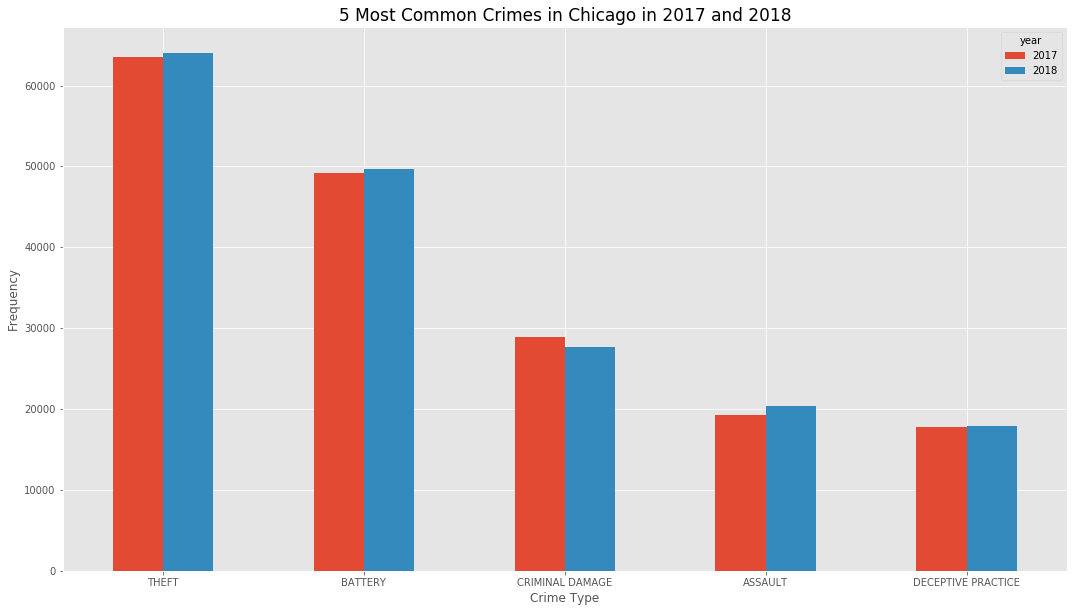

In [11]:
# 5 Most Common Crimes in Chicago

type_cnt_df[:10].Count.unstack().plot.bar(stacked=False, figsize=(18,10), rot=0)
plt.title("5 Most Common Crimes in Chicago in 2017 and 2018", fontsize=17)
plt.xlabel("Crime Type")
plt.ylabel("Frequency")

__*2. How these crimes change over time:*__

In [12]:
year_df = crime_df.groupby(["year"]).size().to_frame("Count")
year_df

,Count
year,
2017,264981
2018,263543


Text(0, 0.5, 'Frequency')

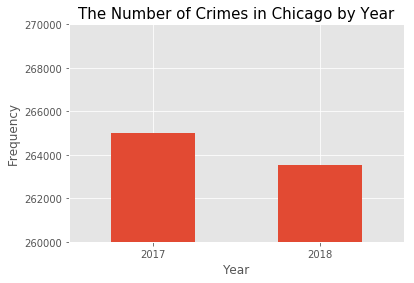

In [13]:
year_df.plot(kind="bar", legend=False, rot=0, ylim=(260000, 270000))
plt.title("The Number of Crimes in Chicago by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Frequency")

__*3. How these crimes are different by neighborhood:*__

In [14]:
neighbor_df = pd.concat([crime_df, pd.get_dummies(crime_df["primary_type"])], axis=1)
variable_list = ["community_area"] + list(neighbor_df["primary_type"].unique())

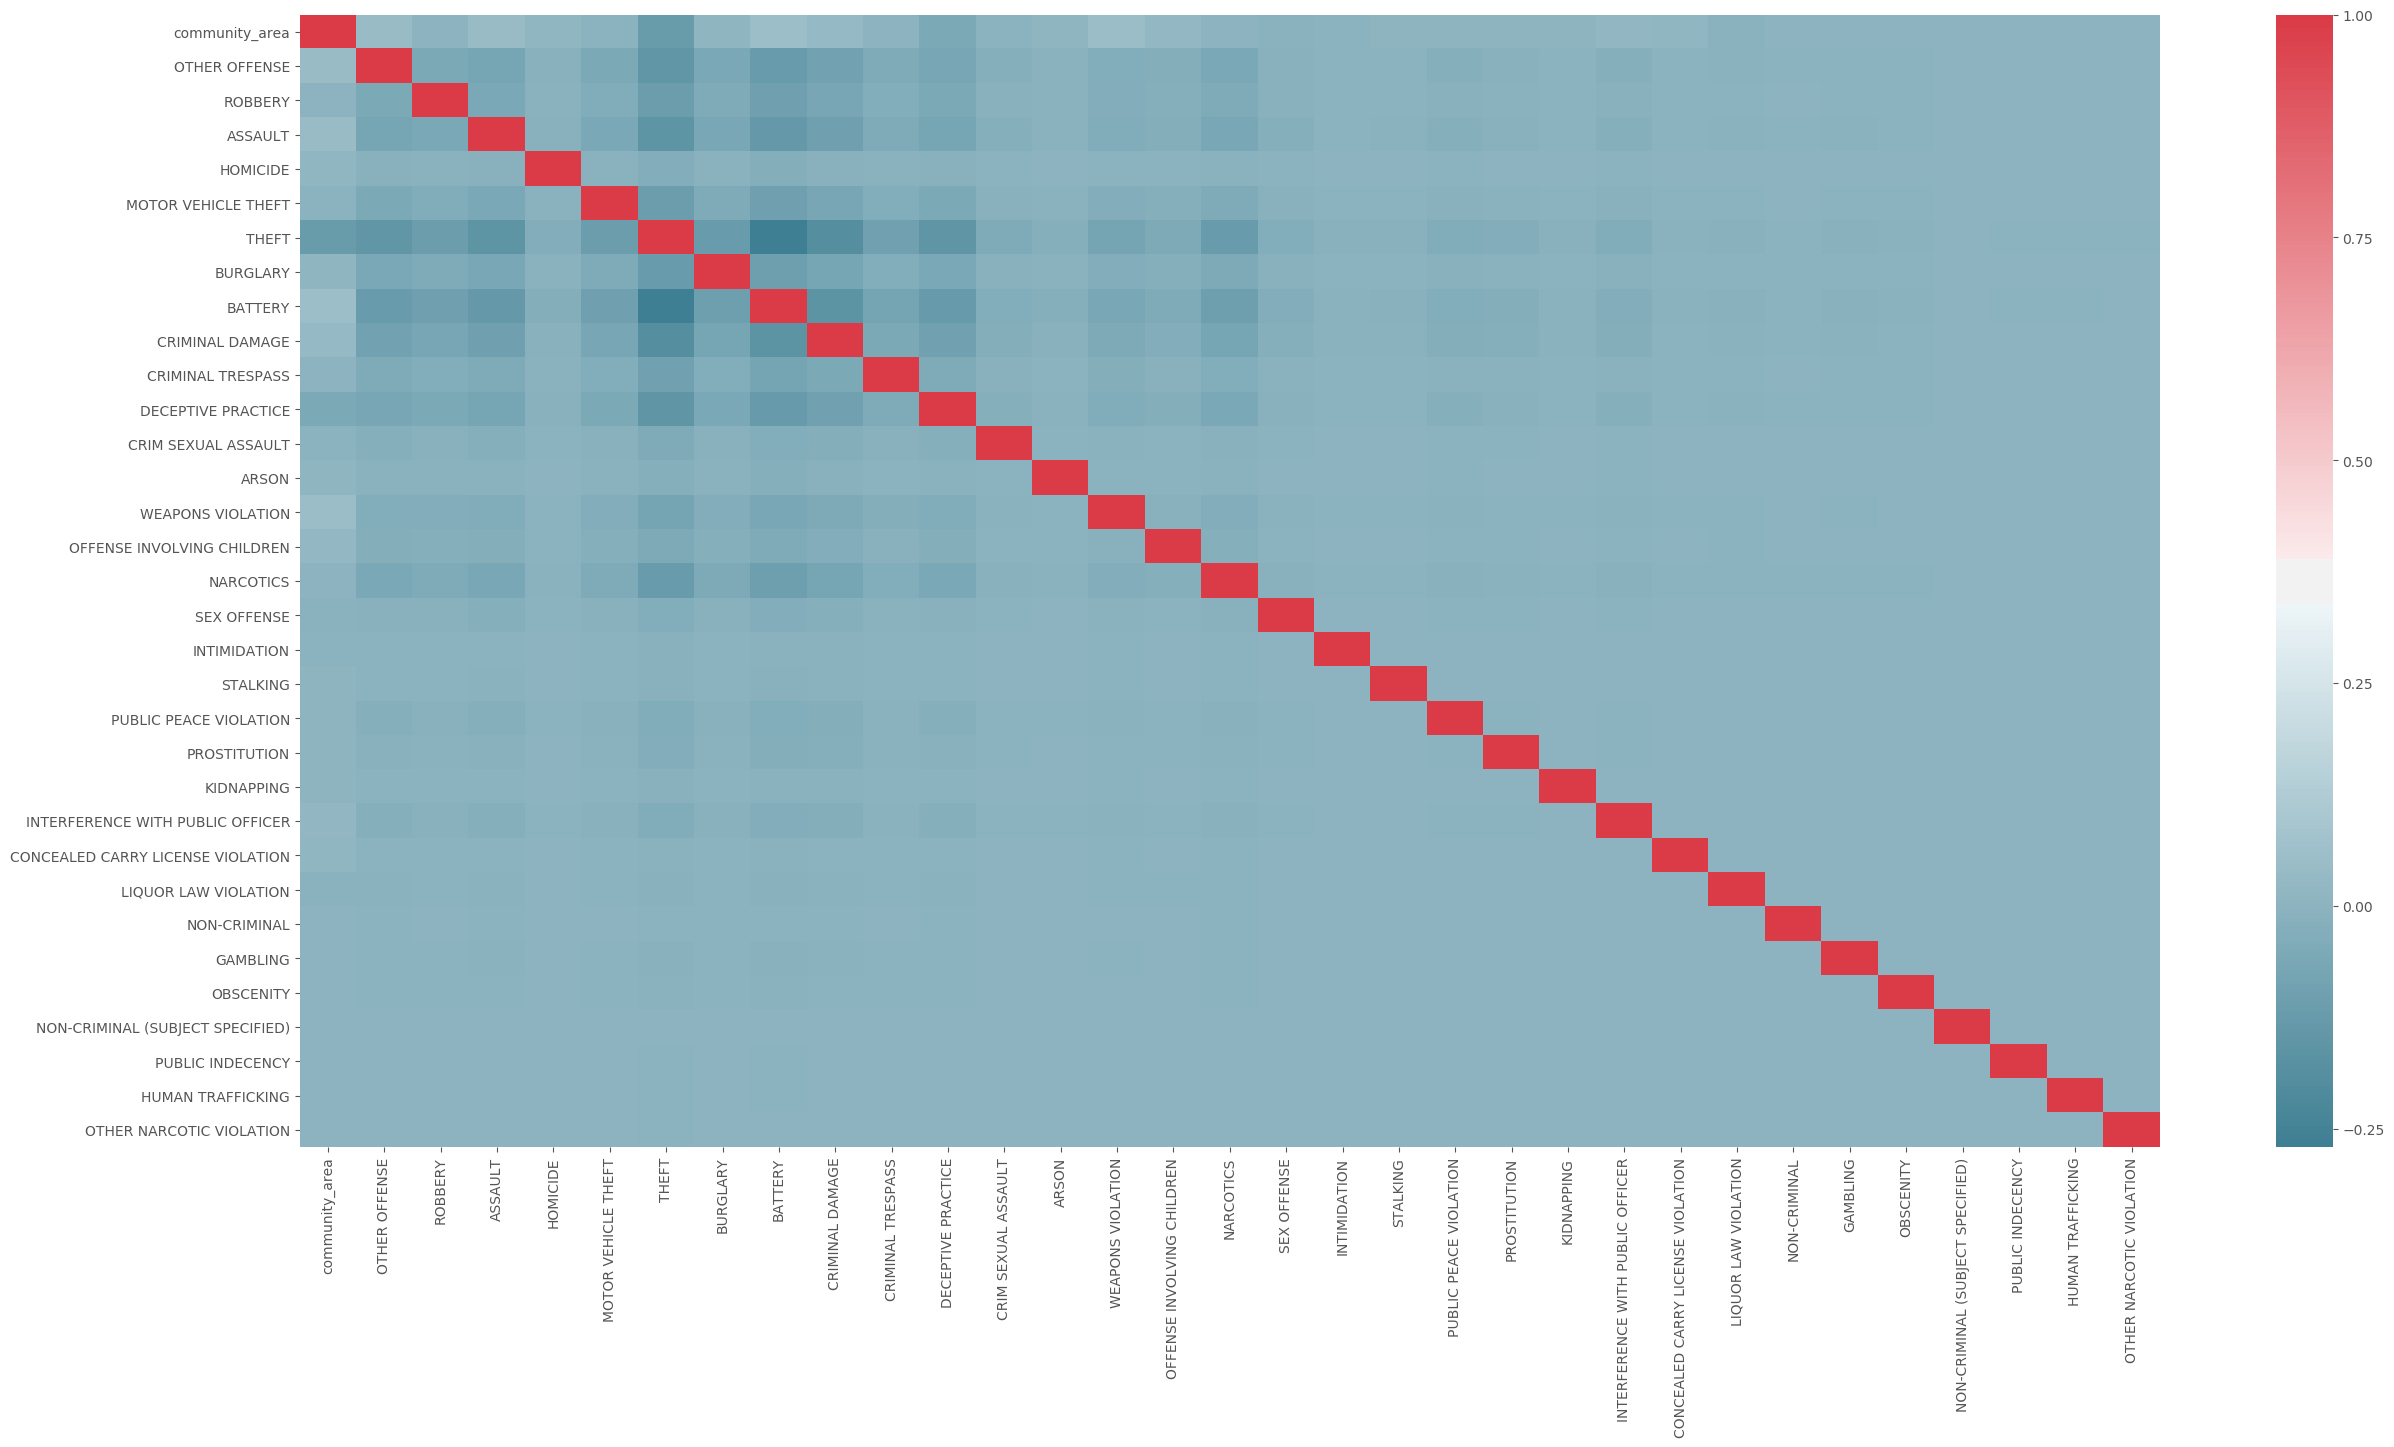

In [15]:
# Create a correlation heatmap between different crime types and community area.
corr = neighbor_df[variable_list].corr()
fig = plt.figure(figsize=(30, 15), dpi=100) 
sns.heatmap(corr, fmt="g", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

From this heatmap, it seems like community area is positively correlated with most of crime types.

Text(0, 0.5, 'Frequency')

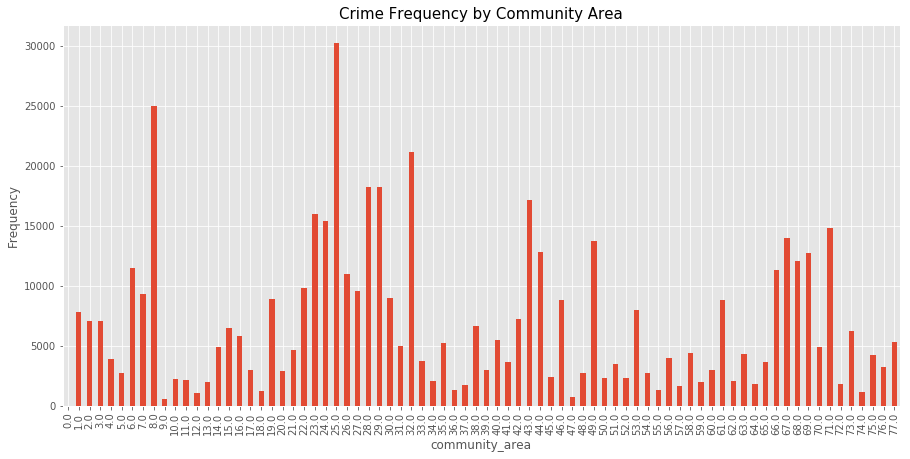

In [16]:
crime_df.groupby(["community_area"]).size().plot(kind="bar", figsize=(15, 7))
plt.title("Crime Frequency by Community Area", fontsize=15)
plt.xlabel("community_area")
plt.ylabel("Frequency")

Although there is no obvious pattern, some community areas definitely have more crimes than others, which supports the observation made from the heatmap.

### __Data Augmentation and APIs__

All of the crime data you just analyzed have a block address and lat/long fields. The task now is to augment that data with American Community Survey data. For each crime report, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block or zipcode where the crime report came from. This could include information about demographics of the block or zipcode (race, income, family size, etc.).

Based on this augmented data, provide some descriptive statistics to describe:

1. What types of blocks have reports of “Battery”?

2. What types of blocks get “Homicide”?

3. Does that change over time in the data you collected?

4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

Using Cenpy, I will get access to ACS 5-Year Dataset.

In [17]:
# 5-Year ACS Dataset for 2017
dataset = "ACSDT5Y2017"
c.explorer.explain(dataset)

{'ACS 5-Year Detailed Tables': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population.  Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups.  Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [18]:
# Connect to the dataset
conn = c.base.Connection("ACSDT5Y2017")
conn

Connection to ACS 5-Year Detailed Tables (ID: https://api.census.gov/data/id/ACSDT5Y2017)

I will be augmenting the crime dataset with block group-level data with:

1. Median Household Income (B19013_001E)
2. Educational Attainment (B23006_001E, B23006_023E)
3. Race, specifically race other than White (B02001_001E, B02001_002E)
4. Citizenship (B05001_001E, B05001_006E)

In [19]:
# Querying for Dataset

variables = ["B19013_001E", "B02001_001E", "B02001_002E", "B05001_001E", "B05001_006E", "B23006_001E", "B23006_023E", "GEO_ID"]
geo_unit = "tract:*"
geo_filter = {"state": "17", "county": "031"}

acs_df = conn.query(variables, geo_unit=geo_unit, geo_filter=geo_filter)
acs_df.rename(columns={"B19013_001E":"Income", "B02001_001E":"Total_race", "B02001_002E": "White_alone", "B05001_001E": "Total_citizen", "B05001_006E": "Not_citizen", "B23006_001E": "Total_edu", "B23006_023E": "Bach_above"}, inplace=True)

# Drop median income below 0 and fix the data type

acs_df["Income"] = acs_df["Income"].astype(int)
acs_df["Total_race"] = acs_df["Total_race"].astype(int)
acs_df["White_alone"] = acs_df["White_alone"].astype(int)
acs_df["Total_citizen"] = acs_df["Total_citizen"].astype(int)
acs_df["Not_citizen"] = acs_df["Not_citizen"].astype(int)
acs_df["Total_edu"] = acs_df["Total_edu"].astype(int)
acs_df["Bach_above"] = acs_df["Bach_above"].astype(int)
acs_df = acs_df[acs_df.Income > 0]

In [20]:
acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400


### __Feature Engineering__

In [21]:
# Create features using the dataset
acs_df["Race_other"] = (acs_df["Total_race"] - acs_df["White_alone"])/acs_df["Total_race"]
acs_df["Citizen"] = (acs_df["Total_citizen"] - acs_df["Not_citizen"])/acs_df["Total_citizen"]
acs_df["Low_edu"] = (acs_df["Total_edu"] - acs_df["Bach_above"])/acs_df["Total_edu"]

acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract,Race_other,Citizen,Low_edu
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000,0.091861,0.977260,0.647235
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100,0.316250,0.910000,0.847668
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500,0.560334,0.664449,0.970852
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100,0.456003,0.680104,0.963100
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400,0.389933,0.656762,0.947177


Since the Chicago Crime Dataset is based on blocks whereas the ACS dataset is based on block group, I need to spatial merge two datasets using the available spatial information.

In [22]:
conn.set_mapservice("tigerWMS_ACS2017")
acs_geodata = conn.mapservice.query(layer=8, where='STATE = 17')
acs_geodata = acs_geodata[["TRACT", "geometry"]]
acs_geodata.rename(columns={"TRACT": "tract"}, inplace=True)

In [23]:
acs_geodata.head()

,tract,geometry
0,002000,POLYGON ((-9904428.386399999 4847994.095700003...
1,807700,POLYGON ((-9770208.138699999 5164415.615199998...
2,807900,"POLYGON ((-9769643.860200001 5161260.4639, -97..."
3,809000,POLYGON ((-9765776.843699999 5169287.108499996...
4,870100,"POLYGON ((-10106515.007 4983976.344999999, -10..."


In [24]:
# Merge acs_df and acs_geodata
merged_acs_df = pd.merge(acs_df, acs_geodata, on=["tract"])

In [25]:
merged_acs_df.head()

,Income,Total_race,White_alone,Total_citizen,Not_citizen,Total_edu,Bach_above,GEO_ID,state,county,tract,Race_other,Citizen,Low_edu,geometry
0,84863,5541,5032,5541,126,3002,1059,1400000US17031561000,17,031,561000,0.091861,0.977260,0.647235,POLYGON ((-9774021.387800001 5129863.688600004...
1,57045,1600,1094,1600,144,965,147,1400000US17031640100,17,031,640100,0.316250,0.910000,0.847668,"POLYGON ((-9767444.9663 5128520.757799998, -97..."
2,44063,6464,2842,6464,2169,3122,91,1400000US17031630500,17,031,630500,0.560334,0.664449,0.970852,"POLYGON ((-9762051.4256 5131215.020900004, -97..."
3,24972,2307,1255,2307,738,1084,40,1400000US17031611100,17,031,611100,0.456003,0.680104,0.963100,"POLYGON ((-9758278.3628 5132361.9366, -9758251..."
4,35016,3298,2012,3298,1132,1647,87,1400000US17031611400,17,031,611400,0.389933,0.656762,0.947177,"POLYGON ((-9759901.5123 5132338.190499999, -97..."


However, because the spatial data for this merged dataset is in a different format as the Chicago Crime Dataset, I must first convert it before I can spatial join two datasets.

In [26]:
merged_acs_gdf = gpd.GeoDataFrame(merged_acs_df, geometry="geometry")
merged_acs_gdf.crs = {"init":"epsg:3395"}
merged_acs_gdf = merged_acs_gdf.to_crs({"init":"epsg:4326"})

In [27]:
# Spatial join Chicago Crime Dataset and ACS Dataset
crime_bg_df = gpd.sjoin(crime_gdf, merged_acs_gdf, op="within")
crime_bg_df = crime_bg_df.reset_index()
crime_bg_df = crime_bg_df[["date", "primary_type", "tract", "year", "Income", "Race_other", "Citizen", "Low_edu"]]
crime_bg_df = crime_bg_df.dropna()
crime_bg_df["Income"] = crime_bg_df["Income"].astype(int)
crime_bg_df["year"] = crime_bg_df["year"].astype(int)
crime_bg_df["tract"] = crime_bg_df["tract"].astype(int)
crime_bg_df["Race_other"] = crime_bg_df["Race_other"].astype(float)
crime_bg_df["Citizen"] = crime_bg_df["Citizen"].astype(float)
crime_bg_df["Low_edu"] = crime_bg_df["Low_edu"].astype(float)

In [28]:
crime_bg_df.head()

,date,primary_type,tract,year,Income,Race_other,Citizen,Low_edu
0,2017-11-28 21:43:00,OTHER OFFENSE,823400,2017,47287,0.562338,0.922649,0.838395
1,2018-01-08 09:36:00,DECEPTIVE PRACTICE,823400,2018,47287,0.562338,0.922649,0.838395
2,2018-01-12 22:13:00,OTHER OFFENSE,823400,2018,47287,0.562338,0.922649,0.838395
3,2018-01-15 17:10:00,OTHER OFFENSE,823400,2018,47287,0.562338,0.922649,0.838395
4,2018-01-17 07:09:00,BATTERY,823400,2018,47287,0.562338,0.922649,0.838395


__*1. What types of blocks have reports of “Battery”?*__


__*2. What types of blocks get “Homicide”?*__

In [29]:
crime_bg_df.describe()

,tract,year,Income,Race_other,Citizen,Low_edu
count,523835.000000,523835.000000,523835.000000,523835.000000,523835.000000,523835.000000
mean,764297.407138,2017.498640,50772.825934,0.597622,0.950486,0.769295
std,105382.544864,0.499999,19817.012186,0.310104,0.062312,0.128320
min,490600.000000,2017.000000,12660.000000,0.005914,0.609947,0.133203
25%,730201.000000,2017.000000,36307.000000,0.319461,0.930352,0.700896
50%,823302.000000,2017.000000,48391.000000,0.583236,0.972450,0.801333
75%,827901.000000,2018.000000,61736.000000,0.907900,0.990907,0.855571
max,842800.000000,2018.000000,202727.000000,1.000000,1.000000,0.986092


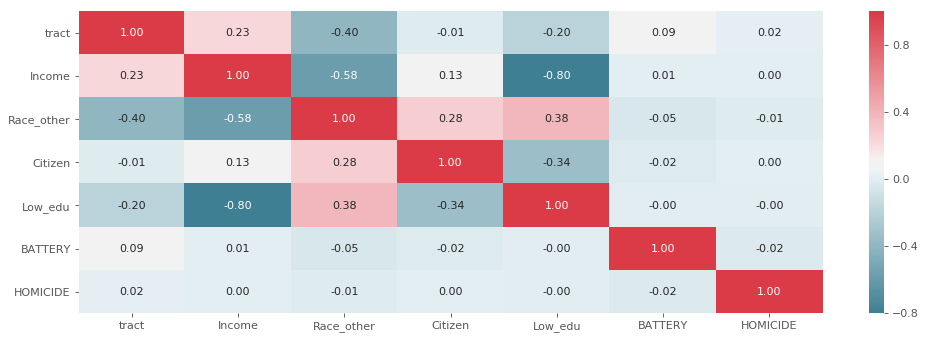

In [30]:
## Create a correlation heatmap of various demographic features and "Battery"/"Homicide"
corr_crime_df = pd.concat([crime_bg_df, pd.get_dummies(crime_bg_df["primary_type"])], axis=1)
corr2 = corr_crime_df[["tract", "Income", "Race_other", "Citizen", "Low_edu", "BATTERY", "HOMICIDE"]].corr()
fig = plt.figure(figsize=(15, 5), dpi=80)
sns.heatmap(corr2, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

The correlation heatmap does not seem to add anything to our understanding of "Battery" and "Homicide."

In [100]:
def get_hist_for_features(df, col_name, filter_name, var_list):
    
    ncols = len(var_list)
    hist_df = df[(df[col_name] == filter_name)]
    hist_df = hist_df[var_list]
    hist_df.hist(figsize=(15, 5))

    return plt.show()

Histograms of "Battery" for all demographical features:

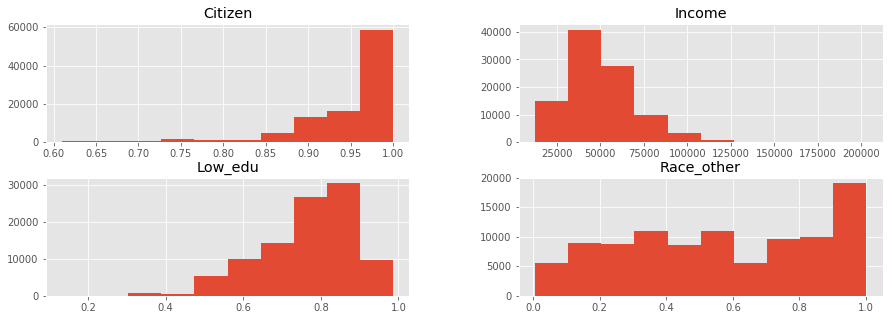

In [101]:
demo_feature_list = ["Citizen", "Income", "Race_other", "Low_edu"]
get_hist_for_features(crime_bg_df, "primary_type", "BATTERY", demo_feature_list)

Similarly, here are histograms of "Homicide" for all demographical features:

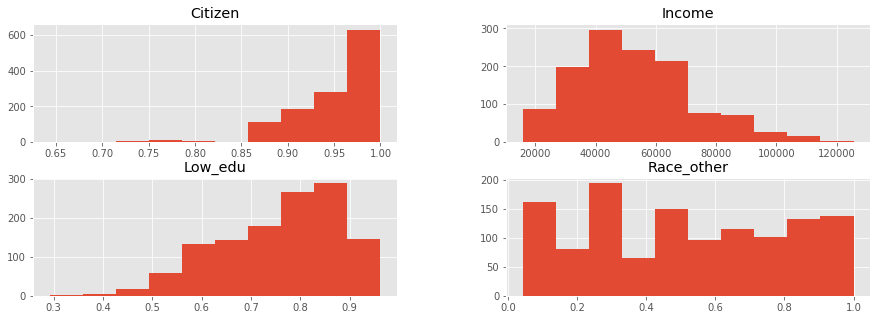

In [102]:
get_hist_for_features(crime_bg_df, "primary_type", "HOMICIDE", demo_feature_list)

It seems like tracts with:
1. higher proportion of US citizens,
2. low median income,
3. higher proportion of people with low education (without Bachelor's degree)

have higher incidents of both batteries and homicides.

As to the proportion of races other than White, however, the relationship is not so clear from the plot.

__*3. Does that change over time in the data you collected?*__

In [93]:
# create weekday column
crime_bg_df['weekday'] = crime_bg_df['date'].dt.dayofweek

In [97]:
def get_plots_by_time(crime_type):
    
    plot_df = crime_bg_df[(crime_bg_df["primary_type"] == crime_type)]
    
    plot_df.groupby(['date', 'primary_type']).size().unstack().plot(figsize=(13,5))
    plot_df.groupby(['year', 'primary_type']).size().unstack().plot(figsize=(13,5))
    plot_df.groupby(['weekday', 'primary_type']).size().unstack().plot(figsize=(13,5))
    
    return plt.show()

Here are some plots showing change over time (by *year* and *date*) for "Battery" and "Homicide."

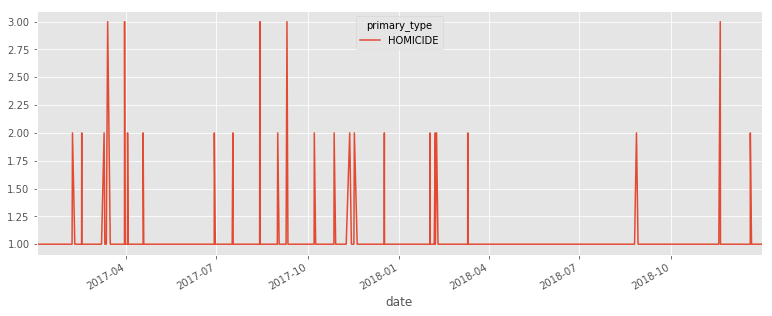

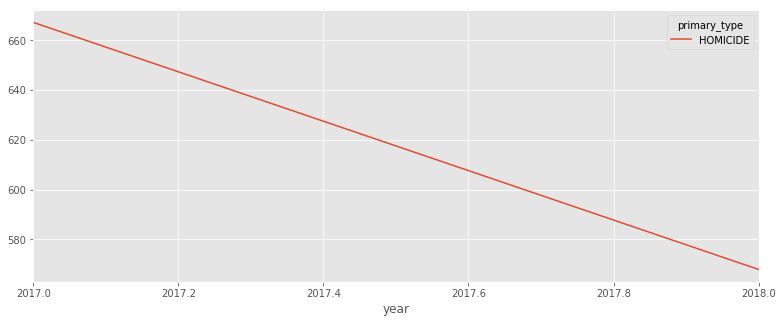

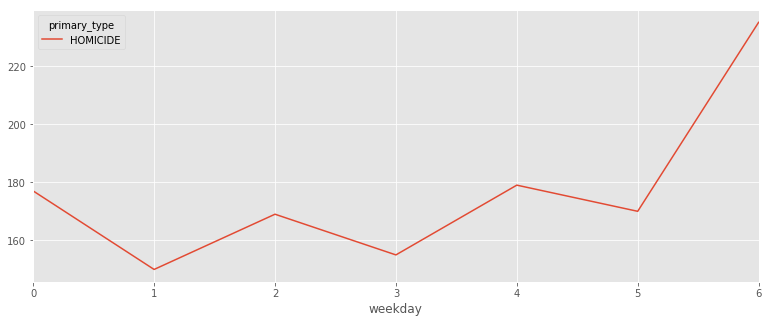

In [98]:
# Get plots to show change over time
get_plots_by_time("HOMICIDE")

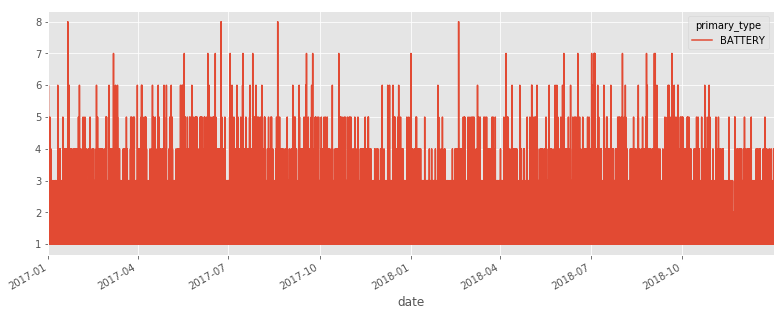

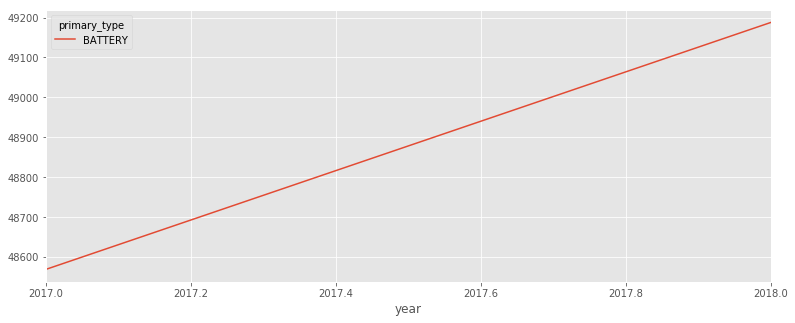

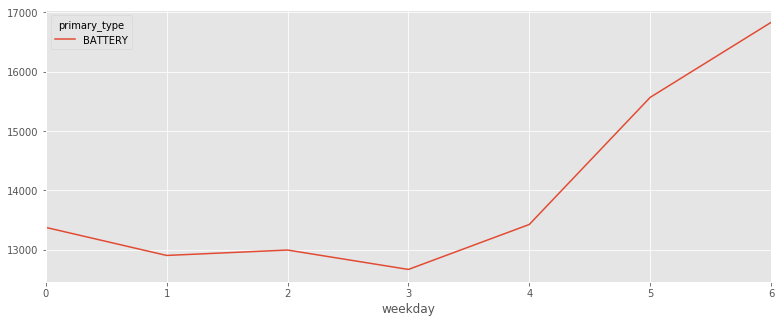

In [99]:
get_plots_by_time("BATTERY")

Considering the fact that batteries are more "common" crime than homicides, it makes sense to see more "spikes" for "Battery." From the data we have, it seems like "Battery" increased over the year while "Homicide" decreased.

Looking these two crimes as a weekly cycle, we see that these crimes occur more on weekends than weekdays.

__*4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?*__

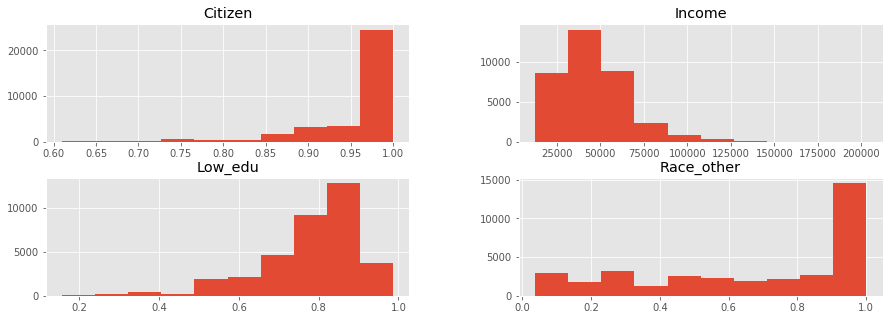

In [103]:
# DECEPTIVE PRACTICE
get_hist_for_features(crime_bg_df, "primary_type", "DECEPTIVE PRACTICE", demo_feature_list)

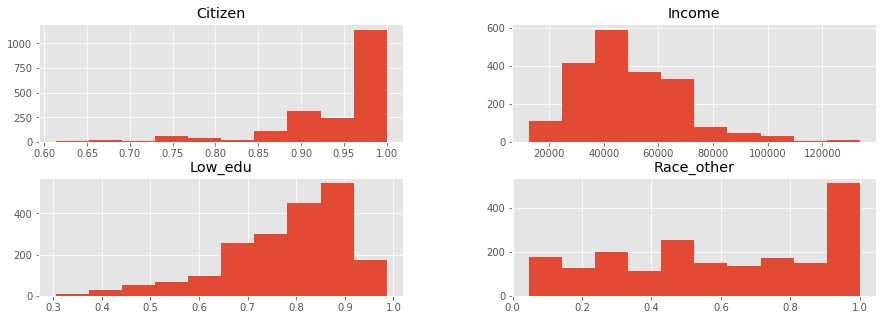

In [104]:
# SEX OFFENSE
get_hist_for_features(crime_bg_df, "primary_type", "SEX OFFENSE", demo_feature_list)

For both __deceptive practice__ and __sex offense__, we see similar patterns as we have previously seen with __battery__ and __homicide__.

There are more __deceptive practices__ and __sex offenses__ in tracts with:
1. Higher proportion of US citizens,
2. Lower median income,
3. Lower educational attainment,
4. Higher proportion of races other than White.

### __Analysis and Communication__

__*1. Describe how crime has changed in Chicago from 2017 to 2018?*__

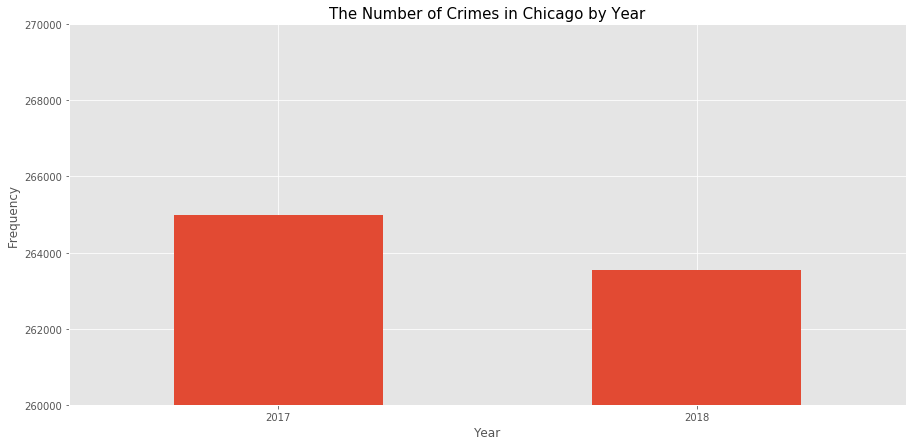

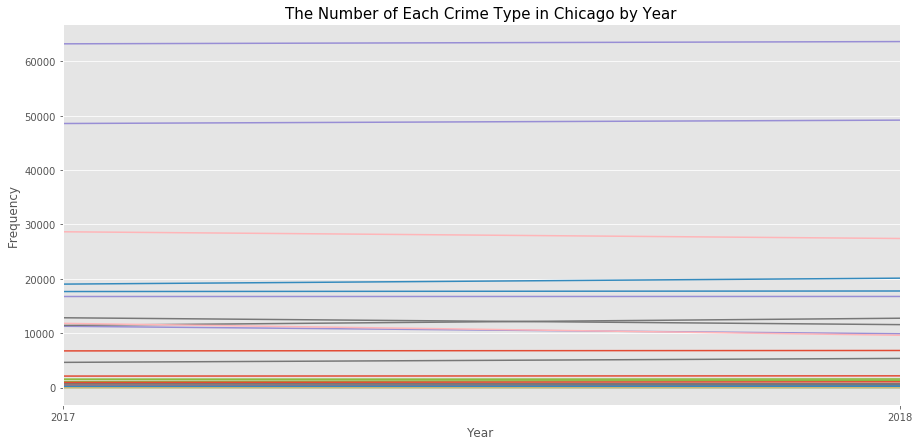

In [123]:
year_df.plot(kind="bar", legend=False, rot=0, ylim=(260000, 270000), figsize=(15,7))
plt.title("The Number of Crimes in Chicago by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Frequency")
crime_bg_df.groupby(['year', 'primary_type']).size().unstack().plot(figsize=(15,7), legend=False, xticks=range(2017, 2019))
plt.title("The Number of Each Crime Type in Chicago by Year", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

Although the overall number of crimes in Chicago decreased, there does not seem to be any radical change for each crime type.

__*2. One of the alderman candidates from recent elections has some crime statistics on his website: https://www.ringer4results.com/node/8*__

First, we will only look at crimes reported between June 26th and July 26th of 2017 and 2018.

In [190]:
# Get Chicago Crime data from June 26th, 2017/2018 to July 26th, 2017/2018
crime_17_df = get_chicago_crime_data("2017-06-26", "2017-07-26")
crime_18_df = get_chicago_crime_data("2018-06-26", "2018-07-26")

In [191]:
# Basic crime data preprocessing

crime_17_df = basic_crime_data_processing(crime_17_df)
crime_18_df = basic_crime_data_processing(crime_18_df)

In [192]:
# Filter for the 43rd Ward
ward_43_17_df = crime_17_df[crime_17_df["ward"] == 43]
ward_43_18_df = crime_18_df[crime_18_df["ward"] == 43]


In [193]:
var_of_int = ["ROBBERY", "BATTERY", "BURGLARY", "MOTOR VEHICLE THEFT"]

ward_43_17_df = ward_43_17_df.loc[ward_43_17_df["primary_type"].isin(var_of_int)]
ward_43_18_df = ward_43_18_df.loc[ward_43_18_df["primary_type"].isin(var_of_int)]

In [194]:
ward_43_17 = ward_43_17_df["primary_type"].value_counts()
ward_43_17

BATTERY                41
ROBBERY                17
BURGLARY               16
MOTOR VEHICLE THEFT     6
Name: primary_type, dtype: int64

In [195]:
ward_43_18 = ward_43_18_df["primary_type"].value_counts()
ward_43_18

BATTERY                37
BURGLARY               14
ROBBERY                11
MOTOR VEHICLE THEFT    10
Name: primary_type, dtype: int64

As we can see, with the exception of motor vehicle theft, other three mentioned crimes have decreased over the same time-frame.

In fact, if we look at the percentage:

In [196]:
for var in var_of_int:
    print("{} in 2018: {}% of that in 2017".format(var, str(round((ward_43_18[var] / ward_43_17[var])*100, 2))))

ROBBERY in 2018: 64.71% of that in 2017
BATTERY in 2018: 90.24% of that in 2017
BURGLARY in 2018: 87.5% of that in 2017
MOTOR VEHICLE THEFT in 2018: 166.67% of that in 2017


Based on the data we have, we cannot accept the statistics of this alderman candidate.

Furthermore, even if the numbers are correct, the conclusions may be misleading given the low number of crimes in his ward since a slight increase in the number of crimes will show a huge increase in percentages.

__*3. As you know, there will be a new mayor in Chicago very soon. Based on these summary statistics, provide 5 key findings to the new mayor’s office about crime in Chicago and what they should focus on in order to deal with crime in Chicago.*__


__*4. What are some of the key caveats of your recommendations and limitations of the analysis that you just did?*__

In [204]:
crime_17 = crime_17_df["primary_type"].value_counts()
crime_18 = crime_18_df["primary_type"].value_counts()
crime_17_set = set(crime_17_df["primary_type"].unique())
crime_18_set = set(crime_18_df["primary_type"].unique())
crime_set = crime_17_set.intersection(crime_18_set)

for crime in crime_set:
    print("{} in 2018: {}% of that in 2017".format(crime, str(round((crime_18[crime] / crime_17[crime])*100, 2))))

INTERFERENCE WITH PUBLIC OFFICER in 2018: 116.07% of that in 2017
NON-CRIMINAL in 2018: 133.33% of that in 2017
KIDNAPPING in 2018: 57.14% of that in 2017
OBSCENITY in 2018: 100.0% of that in 2017
CRIMINAL TRESPASS in 2018: 92.68% of that in 2017
STALKING in 2018: 121.05% of that in 2017
WEAPONS VIOLATION in 2018: 106.29% of that in 2017
CRIM SEXUAL ASSAULT in 2018: 114.93% of that in 2017
GAMBLING in 2018: 252.94% of that in 2017
OTHER OFFENSE in 2018: 102.59% of that in 2017
CONCEALED CARRY LICENSE VIOLATION in 2018: 260.0% of that in 2017
ASSAULT in 2018: 107.75% of that in 2017
BURGLARY in 2018: 94.73% of that in 2017
OFFENSE INVOLVING CHILDREN in 2018: 113.38% of that in 2017
THEFT in 2018: 102.68% of that in 2017
ARSON in 2018: 108.82% of that in 2017
SEX OFFENSE in 2018: 85.57% of that in 2017
BATTERY in 2018: 106.61% of that in 2017
NARCOTICS in 2018: 112.12% of that in 2017
CRIMINAL DAMAGE in 2018: 100.19% of that in 2017
PUBLIC PEACE VIOLATION in 2018: 84.14% of that in 2017


__*Based on these summary statistics and the data exploration, several suggestions can be made:*__
1. Considering the fact that the overall number of crimes decreased over the year, they should maintain the current efforts to fight crimes in the city. 
2. However, theft being one of the highest crimes committed in Chicago, they should look for ways to lower the number of thefts. 
3. To further decrease the number of crimes, they should focus more of their efforts in fighting crimes on Fridays and Weekends,
4. They can focus on coming up with specific measures for few specific crime types such as gambling and concealed carry license violation, which increased most radically over the year.
5. Consistent with the existing literature on socioeconomic status and crimes, neighborhoods with low education and low income are still vulnerable to crimes. In the short term, more police patrols on these neighborhoods could lower the number of crimes. However, as a long-term strategy, they should think about a way to increase education and income in those neighborhoods. 

__*Some of the key caveats and limitations of the analysis are:*__
1. Because we did not run any statisical tests on the data, we cannot be sure whether the difference we see between 2017 and 2018 is statiscally and economically meaningful. It is very much possible that nothing really changed despite the slight decrease in number of crimes.
2. Furthermore, for the convenience of the analysis, we excluded all data entries with empty latitude or longitude information. If there are some patterns in the missing data, this analysis would not be able to catch such patterns.

### Question 3

Assume you are running the 911 call center for Chicago. You get a call from someone at 2111 S Michigan Ave

__*1. Of the types of crimes you have data for, which crime type is the most likely given the call came from 2111 S Michigan Ave? What are the probabilities for each type of request?*__

A call from 2111 S Michigan Ave will be recorded as "021XX S MICHIGAN AVE" for "block" in our dataset.

Therefore, we should look at the data where "block" == "021XX S MICHIGAN AVE".

In [216]:
ma_crime_df = crime_df[crime_df["block"] == "021XX S MICHIGAN AVE"]
ma_crime_list = list(ma_crime_df["primary_type"].unique())
total_crime = ma_crime_df["primary_type"].count()
ma_crime = ma_crime_df["primary_type"].value_counts()

__Battery__ is most likely given the call came from 2111 S Michigan Avenue. Below are the probabilities for each type of crimes reported in 21XX S Michigan Avenue.

In [222]:
for crime in ma_crime_list:
    print("{}: {}".format(crime, str(round(ma_crime[crime] / total_crime, 2))))

DECEPTIVE PRACTICE: 0.1
ROBBERY: 0.03
BATTERY: 0.27
ASSAULT: 0.1
THEFT: 0.1
OTHER OFFENSE: 0.2
BURGLARY: 0.02
CRIMINAL DAMAGE: 0.1
CRIMINAL TRESPASS: 0.02
PUBLIC PEACE VIOLATION: 0.02
MOTOR VEHICLE THEFT: 0.03


__*2. Let’s now assume that a call comes in about Theft. Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?*__

Because both __Garfield Park__ and __Uptown__ are Neighborhood-level labels, we will download the neighborhood spatial data from the Chicago Data Portal that we can spatial join to our crime dataset.

In [228]:
import requests
import json

In [230]:
def get_gdf_from_geojson(url):

    r = requests.get(url)
    data = r.json()
    data_gdf = gpd.GeoDataFrame.from_features(data['features'])

    return data_gdf

In [245]:
neighbor_url = "https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON"

neighbor_gdf = get_gdf_from_geojson(neighbor_url)
neighbor_gdf = neighbor_gdf[["pri_neigh", "geometry"]]
neighbor_gdf = neighbor_gdf.rename(columns={"pri_neigh": "neighborhood"})
neighbor_gdf.crs = {"init":"epsg:4326"}

In [246]:
neighbor_gdf.head()

,neighborhood,geometry
0,Grand Boulevard,(POLYGON ((-87.60670812560372 41.8168137713739...
1,Printers Row,(POLYGON ((-87.62760697485348 41.8743709778537...
2,United Center,(POLYGON ((-87.66706868914602 41.8888518776954...
3,Sheffield & DePaul,(POLYGON ((-87.65833494805533 41.9216614422918...
4,Humboldt Park,(POLYGON ((-87.74059567509266 41.8878231689323...


In [247]:
crime_neighbor_df = gpd.sjoin(crime_gdf, neighbor_gdf, op="within")

In [267]:
# Simple Data Preprocessing
crime_neighbor_df = crime_neighbor_df.reset_index()[["date", "primary_type", "neighborhood"]]
total_theft = crime_neighbor_df[crime_neighbor_df["primary_type"] == "THEFT"].shape[0]
gp_theft = crime_neighbor_df[(crime_neighbor_df["neighborhood"] == "Garfield Park") & (crime_neighbor_df["primary_type"] == "THEFT")].shape[0]
up_theft = crime_neighbor_df[(crime_neighbor_df["neighborhood"] == "Uptown") & (crime_neighbor_df["primary_type"] == "THEFT")].shape[0]

In [273]:
print("Given that a call came in about theft:")
for number, neighborhood in [(gp_theft, "Garfield Park"), (up_theft, "Uptown")]:
    print("The likelihood that the call came from {} is {}".format(neighborhood, str(round(number / total_theft, 5))))

Given that a call came in about theft:
The likelihood that the call came from Garfield Park is 0.01962
The likelihood that the call came from Uptown is 0.01539


__*Therefore, it is more likely that the call came from Garfield Park than from Uptown by approximately 0.004.*__